In [93]:
# Import Library 

import numpy as np
import matplotlib.pyplot as plt
import time, tracemalloc

In [101]:
# Functions Library

# Evaluating function using values from Coefficient array (Setting)
def eval_poly(x, coeffs):
    # coeffs[k] multiplies x^k
    powers = np.vstack([x**k for k in range(len(coeffs))])  # shape (K, N)
    return (coeffs[:, None] * powers).sum(axis=0)

# Formatting + Threshholding Condition
def format_poly(coeffs, var="x", thresh=1e-10):
    terms = []
    for k, c in enumerate(coeffs):
        if abs(c) < thresh:
            continue
        if k == 0:
            terms.append(f"{c:+.5g}")
        elif k == 1:
            terms.append(f"{c:+.5g}·{var}")
        else:
            terms.append(f"{c:+.5g}·{var}^{k}")
    return " ".join(terms) if terms else "0"

# ---- Evidence + MAP in parameter space (fixed alpha, sigma2) ----

# Log-evidence in parameter space (fixed alpha, sigma2)
# -------------------------
def log_evidence_param(G_active, b_active, yTy, alpha, sigma2, T):
    """
    Compute log p(y) for a given active set using parameter-space form.
    
    Definitions/ Equations:
      G = theta^T_active * theta_active : gram matrix
      beta = 1 / sigma2
      Lambda = alpha * I + beta * G_active
      log p(y) = -1/2 [ T*log(2*pi) + T*log(sigma2) + log|Lambda|
                        - M_active*log(alpha)
                        + beta * y^T y - beta^2 * b_active^T Lambda^{-1} b_active ]
                        
    Inputs:
      G_active : (M_active, M_active) Gram submatrix for active features
      b_active : (M_active)          cross-term vector of Theta_active^T y (b_active = Theta_active^T @ y)
      yTy      : scalar               y^T y
      alpha, sigma2 : fixed hyperparameters
      T        : number of samples
    """
    M_active = G_active.shape[0] # row of G_active(curr G)
    beta = 1.0 / sigma2

    # Lambda = alpha I + beta G_active
    Lambda = alpha * np.eye(M_active) + beta * G_active

    # log|Lambda| using slogdet
    sign, logdet_Lambda = np.linalg.slogdet(Lambda)

    # Solve for Lambda^{-1} b_active 
    Lambda_inv_b = np.linalg.solve(Lambda, b_active)             #TODO: might have to consider cholesky for computational stabillity/speed

    # Quadratic piece: beta * y^T y - beta^2 * b_active^T Lambda^{-1} b_active
    quad = beta * yTy - (beta**2) * (b_active @ Lambda_inv_b)

    # Full log-evidence
    logev = -0.5 * (T * np.log(2.0 * np.pi) + T * np.log(sigma2)
                    + logdet_Lambda - M_active * np.log(alpha) + quad)
    return float(logev)

def map_coeffs_from_G(G_active, b_active, alpha, sigma2):
    """
    Definitions/ Equations:
    m_N = β Λ^{-1} b_A  with Λ = α I + β G_A, β=1/σ^2

    beta   = 1 / sigma2
    Lambda = alpha I + beta G_active
    m_N    = beta * Lambda^{-1} b_active
      
    Returns (mN, the xi_MAP) for the active set.
    """ 
    M_active = G_active.shape[0]                                  #size of the row of G            
    beta = 1.0 / sigma2
    Lambda = alpha * np.eye(M_active) + beta * G_active           #TODO: might have to consider cholesky for computational stabillity/speed
    mN = beta * np.linalg.solve(Lambda, b_active)
    return mN

# ---- Greedy backward elimination (fixed alpha, sigma2) ----

def backward_evidence_selection(Theta, y, alpha, sigma2, tol=0.0, verbose=True):
    """
    Basic algorithm
    
    1. Start with all features active. 
    2. At each step, try removing each active feature.
    3. Pick the removal that maximizes log-evidence; accept it if it improves over current log-evidence by > tol. 
    4. Stop when converges/ no improvement.
    5. Repeat
    
    Returns:
      active     : sorted list of kept feature indices
      xi_hat     : MAP coefficients padded with zeros for removed terms
      evaluation    : list of (active_indices_tuple, log_evidence)
    """
    T, M = Theta.shape
    y = np.asarray(y)
    yTy = float(y @ y)           # y^T y (reused in every evidence call)

    # Precompute global Gram G = Theta^T Theta and the cross term b = Theta^T y.
    # For any active set A, we'll slice G_active = G[A, A], b_active = b[A].
    G = Theta.T @ Theta
    b = Theta.T @ y

    # Start with all features active
    active = list(range(M))
    evaluation = []

    # Evidence of the full model (Initial Evidence calc)
    G_active = G[active][:, active]                #fixed slcing issue (only returning diagonal issue)
    b_active = b[active]
    best_ev = log_evidence_param(G_active, b_active, yTy, alpha, sigma2, T)
    evaluation.append((tuple(active), best_ev))
    if verbose:
        print(f"Initial log ev: |A|={len(active)}, log-evidence={best_ev:.6f}")

    improved = True
    while improved and len(active) > 1:            #stopping condition
        improved = False                           # will change to True if there is an improvement
        best_drop_ev = -np.inf                     # set as neg inf to start with
        best_drop_idx = None                       # Empty

        # Consider dropping each active feature once
        for j_local, j in enumerate(active):
            # Trial active set: remove the j-th feature (by position j_local)
            trial = active.copy()
            trial.pop(j_local)

            # Build trial G and b submatrix via slicing from precomputed G, b
            G_trial = G[trial][:, trial]
            b_trial = b[trial]

            # Evidence of the trial model
            ev_trial = log_evidence_param(G_trial, b_trial, yTy, alpha, sigma2, T)

            # Track and update best single-feature drop
            if ev_trial > best_drop_ev:
                best_drop_ev = ev_trial
                best_drop_idx = j

        # Accept the best drop if it improves evidence by more than tol
        if best_drop_ev > best_ev + tol:                           # TODO: Might have to consider Tol -> Bayes ratio 
            active.remove(best_drop_idx)
            best_ev = best_drop_ev
            evaluation.append((tuple(active), best_ev))            
            improved = True                                        # switch back on
            if verbose:
                print(f"drop {best_drop_idx:>2d}: |A|={len(active)}, updated log-evidence={best_ev:.6f}")
        else:
            if verbose:
                print("no removal improves evidence; stop.")
            break

    # Final MAP (posterior mean) on the selected set; pad zeros for removed terms
    G_active = G[active][:, active]
    b_active = b[active]
    mN_active = map_coeffs_from_G(G_active, b_active, alpha, sigma2)

    xi_hat = np.zeros(M)                               # create full zero xi library
    xi_hat[np.array(active, dtype=int)] = mN_active    # Fill in the library with final active mNs
    return active, xi_hat, evaluation


def forward_evidence_selection(Theta, y, alpha, sigma2, tol=0.0, verbose=True):
    """
    Procedure:
      1. Start with an empty active set.
      2. At each step, try adding each inactive feature one at a time.
      3. Select the addition that yields the largest log-evidence.
      4. Accept it if it improves current log-evidence by > tol; else stop.

    Returns:
      active     : list of selected feature indices (in the order they were added)
      xi_hat     : MAP coefficients (zeros in inactive positions)
      evaluation : list of (tuple(active_indices), log_evidence) after each accepted step
    """
    # Shapes and reusable scalars
    T, M = Theta.shape
    y = np.asarray(y)
    yTy = float(y @ y)

    # Precompute once: G = Theta^T Theta, b = Theta^T y
    G = Theta.T @ Theta
    b = Theta.T @ y

    active = []             #empty initial list
    evaluation = []         #initialize tracking list

    # Current evidence for the starting model
    beta = 1.0 / sigma2
 
    # Empty model: C = sigma^2 I, evidence gives --> pure-noise model
    best_ev = -0.5 * (T * np.log(2.0 * np.pi) + T * np.log(sigma2) + beta * yTy)

    evaluation.append((tuple(active), best_ev))
    if verbose:
        print(f"start (forward): |A|={len(active)}, log-evidence={best_ev:.6f}")

    improved = True
    while improved and len(active) < M:
        improved = False
        best_add_ev = -np.inf
        best_add_idx = None

        # Inactive features are those not yet in 'active'
        inactive = [j for j in range(M) if j not in active]

        # Try adding each inactive feature once
        for j in inactive:
            trial = active + [j]

            # Build trial G and b submatrix via slicing from precomputed G, b
            G_trial = G[trial][:, trial]
            b_trial = b[trial]

            # Evidence of the trial model
            ev_trial = log_evidence_param(G_trial, b_trial, yTy, alpha, sigma2, T)

            # Track the best single-feature addition
            if ev_trial > best_add_ev:
                best_add_ev = ev_trial
                best_add_idx = j

        # Accept the best addition if it improves evidence by more than tol
        if best_add_ev > best_ev + tol and best_add_idx is not None:
            active.append(best_add_idx)
            best_ev = best_add_ev
            evaluation.append((tuple(active), best_ev))
            improved = True
            if verbose:
                print(f" add {best_add_idx:>2d}: |A|={len(active)}, updated log-evidence={best_ev:.6f}")
        else:
            if verbose:
                print("no addition improves evidence; stop.")
            break

    # Final MAP (posterior mean) on the selected set, zeros for removed terms
    if len(active) == 0:
        xi_hat = np.zeros(M)
    else:
        G_active = G[active][:, active]
        b_active = b[active]
        mN_active = map_coeffs_from_G(G_active, b_active, alpha, sigma2)
        xi_hat = np.zeros(M)
        xi_hat[np.array(active, dtype=int)] = mN_active

    return active, xi_hat, evaluation

In [105]:
# Setting for the model

N = 200                    # number of samples
X_MIN, X_MAX = -1.0, 1.0   # sampling range for x
DEGREE = 10                # full polynomial library up to power DEGREE
NOISE_FRAC = 0.05          # noise level as fraction of std(y_true)
TRUE_COEFFS = np.array([3.0, 0.0, -3.0, 0.0, 0.0, 1.0]) # tested model

# generating coordinates 

x = np.linspace(X_MIN, X_MAX, N)
y_true = eval_poly(x, TRUE_COEFFS)

# Add Gaussian noise to y

y = y_true + NOISE_FRAC * np.std(y_true) * np.random.randn(N) #normaly distributed error

# Variables in Theta (Library)

Theta = np.vander(x, N=DEGREE+1, increasing=True) # shape (N, DEGREE+1)

# HYPERPARAMETMERS SETTING

sigma2 = 0.01                                # initial guess
alpha  = 1.0                                 # isotropic prior precision


Initial log ev: |A|=11, log-evidence=220.199236
drop  1: |A|=10, updated log-evidence=222.922378
drop  3: |A|=9, updated log-evidence=224.596381
drop  9: |A|=8, updated log-evidence=225.363642
drop  7: |A|=7, updated log-evidence=226.870181
drop 10: |A|=6, updated log-evidence=227.472523
drop  8: |A|=5, updated log-evidence=228.290835
drop  6: |A|=4, updated log-evidence=229.334111
drop  4: |A|=3, updated log-evidence=231.590346
no removal improves evidence; stop.

[backward] Selected active indices: [0, 2, 5]
[backward] Discovered polynomial: y(x) = +3.013 -3.0239·x^2 +0.98952·x^5

Evaluation list;
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), 220.19923649115088)
((0, 2, 3, 4, 5, 6, 7, 8, 9, 10), 222.92237759354515)
((0, 2, 4, 5, 6, 7, 8, 9, 10), 224.59638103885192)
((0, 2, 4, 5, 6, 7, 8, 10), 225.36364188989825)
((0, 2, 4, 5, 6, 8, 10), 226.87018148113998)
((0, 2, 4, 5, 6, 8), 227.47252280865519)
((0, 2, 4, 5, 6), 228.29083471841255)
((0, 2, 4, 5), 229.33411140614226)
((0, 2, 5), 231.59034558

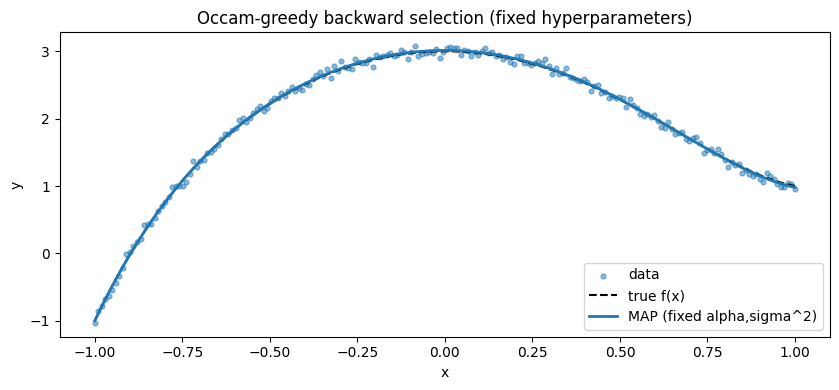

In [106]:
active, xi_hat, eval_b = backward_evidence_selection(Theta, y, alpha, sigma2, tol=0.0, verbose=True)

print("\n[backward] Selected active indices:", active)
print("[backward] Discovered polynomial: y(x) =", format_poly(xi_hat))
print("\nEvaluation list;") 
[print(_) for _ in eval_b]

# Plot fit vs Truth
y_map = Theta @ xi_hat
plt.figure(figsize=(8.5,4))
plt.scatter(x, y, s=12, alpha=0.5, label="data") 
plt.plot(x, y_true, "k--", label="true f(x)")
plt.plot(x, y_map, label="MAP (fixed alpha,sigma^2)", linewidth=2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Occam-greedy backward selection (fixed hyperparameters)")
plt.legend(); plt.tight_layout(); plt.show()

start (forward): |A|=0, log-evidence=-48788.850768
 add  0: |A|=1, updated log-evidence=-8993.428212
 add  2: |A|=2, updated log-evidence=-700.591646
 add  5: |A|=3, updated log-evidence=231.590346
no addition improves evidence; stop.

[Forward] Selected indices: [0, 2, 5]
[Forward] Discovered polynomial: +3.013 -3.0239·x^2 +0.98952·x^5

Evaluation list;
((), np.float64(-48788.850767599244))
((0,), -8993.428211722143)
((0, 2), -700.5916458422354)
((0, 2, 5), 231.5903455847773)


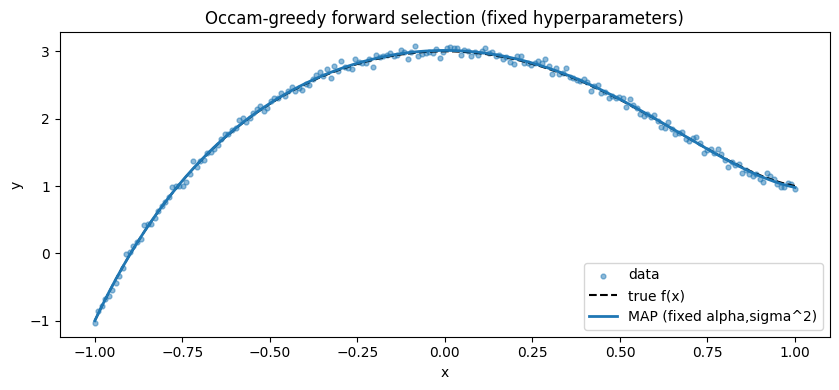

In [107]:
active_fwd, xi_hat_fwd, eval_f = forward_evidence_selection(Theta, y, alpha, sigma2, tol=0.0, verbose=True)

print("\n[Forward] Selected indices:", active_fwd)
print("[Forward] Discovered polynomial:", format_poly(xi_hat_fwd))
print("\nEvaluation list;") 
[print(_) for _ in eval_f]

# Plot fit vs Truth
y_map_fwd = Theta @ xi_hat_fwd
plt.figure(figsize=(8.5,4))
plt.scatter(x, y, s=12, alpha=0.5, label="data") 
plt.plot(x, y_true, "k--", label="true f(x)")
plt.plot(x, y_map_fwd, label="MAP (fixed alpha,sigma^2)", linewidth=2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Occam-greedy forward selection (fixed hyperparameters)")
plt.legend(); plt.tight_layout(); plt.show()
